<a href="https://colab.research.google.com/github/whistle-hikhi/Object-Localization/blob/main/Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U git+http://github.com/albumentations-team/albumentations
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning http://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ud0m72z8
  Running command git clone --filter=blob:none --quiet http://github.com/albumentations-team/albumentations /tmp/pip-req-build-ud0m72z8
  Resolved http://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125696 sha256=ed94cef9c27f00254e23ba34f0e2dbf52958ceea6775ba267ac9cf745e653bca
  Stored in directory: /tmp/pip-ephem-wheel-cache-2dzlkl8r/wheels/97/57/c2/c89ae91abd761dee7aa61a61730ef88a65d73e2c1f968b8137
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Look

In [ ]:
!git clone http://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 9.89 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

## Configurations

In [ ]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [ ]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


## Understand the dataset

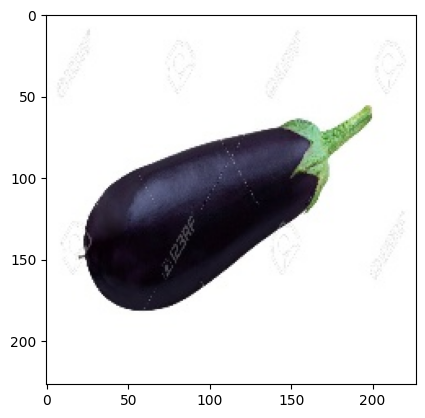

In [ ]:
row = df.iloc[100]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

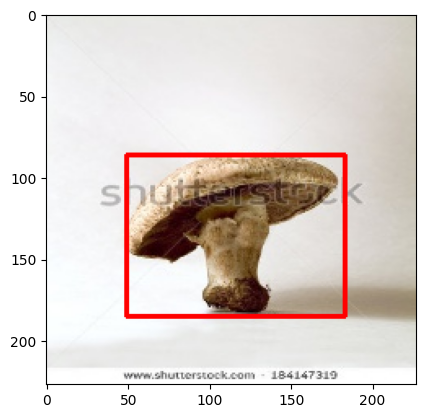

In [ ]:
row = df.iloc[2]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255,0,0),2)

plt.imshow(bnd_box_img)

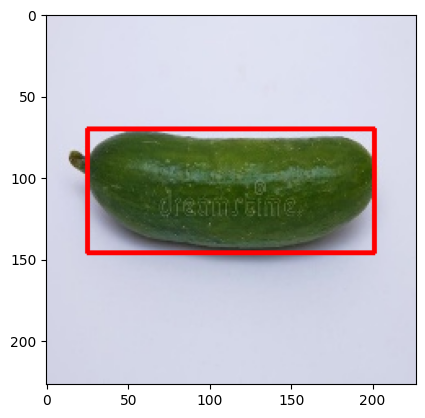

In [ ]:
row = df.iloc[20]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255,0,0),2)

plt.imshow(bnd_box_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

## Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.HorizontalFlip(p = 0.5),
            A.VerticalFlip(p = 0.5),
            A.Rotate()
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

In [ ]:
valid_augs = A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

## Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):

    def __init__(self,df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):

        row = self.df.iloc[idx]

        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax

        bbox = [[xmin, ymin, ymax, ymax]]

        img_path = DATA_DIR + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
            img = data['image']
            bbox = data['bboxes'][0]

        img = torch.from_numpy(img).permute(2,0,1) / 255.0 #(h,w,c) -> (c,h,w)
        bbox = torch.Tensor(bbox)

        return img, bbox

In [ ]:
trainset = ObjLocDataset(train_df,train_augs)
validset = ObjLocDataset(valid_df,valid_augs)

In [ ]:
print(f'Total examples in the trainset: {len(trainset)}')
print(f'Total examples in the valid: {len(validset)}')

Total examples in the trainset: 148
Total examples in the valid: 38


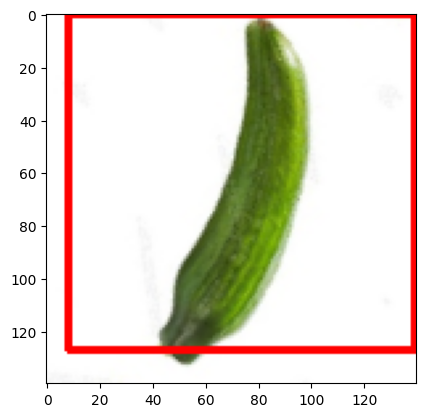

In [ ]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox
pt1 = (int(xmin),int(ymin))
pt2 = (int(xmax),int(ymax))

bnd_img = cv2.rectangle(img.permute(1,2,0).numpy(),pt1,pt2,(255,0,0),2)
plt.imshow(bnd_img)

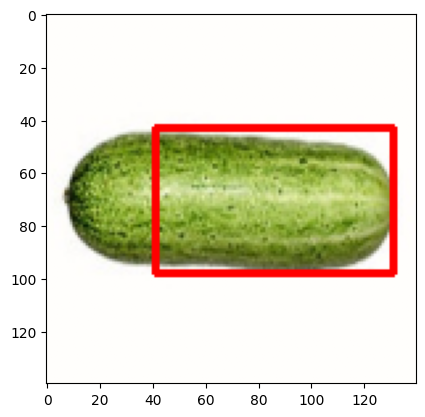

In [ ]:
img, bbox = trainset[19]

xmin, ymin, xmax, ymax = bbox
pt1 = (int(xmin),int(ymin))
pt2 = (int(xmax),int(ymax))

bnd_img = cv2.rectangle(img.permute(1,2,0).numpy(),pt1,pt2,(255,0,0),2)
plt.imshow(bnd_img)

## Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
print(f'Total no. batches in trainloader: {len(trainloader)}')
print(f'Total no. batches in validloader: {len(validloader)}')


Total no. batches in trainloader: 10
Total no. batches in validloader: 3


In [ ]:
for images, bboxes in trainloader:
    break

print(f'Shape of one batch images: {images.shape}')
print(f'Shape of one batch bboxes: {bboxes.shape}')

Shape of one batch images: torch.Size([16, 3, 140, 140])
Shape of one batch bboxes: torch.Size([16, 4])


## Create Model

In [ ]:
from torch import nn
import timm

In [ ]:
class ObjLocModel(nn.Module):

      def __init__(self):
          super(ObjLocModel, self).__init__()

          self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)


      def forward(self,images,gt_bboxes = None):
          bboxes = self.backbone(images)

          if gt_bboxes != None:
              loss = nn.MSELoss()(bboxes, gt_bboxes)
              return bboxes, loss

          return bboxes

In [ ]:
model = ObjLocModel()
model.to(DEVICE)

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

## Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train() # Dropout ON

    for data in tqdm(dataloader):

        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images, gt_bboxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval() # Dropout OFF

    with torch.no_grad():
        for data in tqdm(dataloader):

            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)
            total_loss += loss.item()

        return total_loss / len(dataloader)

## Training

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print('WEIGHTS-ARE-SAVED')
        best_valid_loss = valid_loss

    print(f'Epoch: {i+1} train loss: {train_loss} valid loss: {valid_loss}')


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 1 train loss: 5036.689599609375 valid loss: 3597.2003580729165


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 2 train loss: 2144.5890380859373 valid loss: 2421.830810546875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 3 train loss: 1278.5658325195313 valid loss: 740.5379638671875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 4 train loss: 837.9066345214844 valid loss: 279.8610026041667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 5 train loss: 583.3313293457031 valid loss: 203.0732676188151


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6 train loss: 407.24061889648436 valid loss: 247.22245279947916


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 7 train loss: 344.04293365478514 valid loss: 192.22017415364584


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 8 train loss: 242.11162872314452 valid loss: 186.47884114583334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 train loss: 216.3499755859375 valid loss: 213.4991912841797


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 train loss: 186.26326217651368 valid loss: 188.74280293782553


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 train loss: 153.58698654174805 valid loss: 191.9187978108724


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 train loss: 150.32639694213867 valid loss: 197.3212687174479


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 13 train loss: 142.64653396606445 valid loss: 182.70428466796875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 14 train loss: 141.6691566467285 valid loss: 162.9428914388021


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 15 train loss: 142.48337326049804 valid loss: 152.47437540690103


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 16 train loss: 135.9941436767578 valid loss: 141.64629109700522


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 train loss: 135.09456329345704 valid loss: 167.2090810139974


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18 train loss: 124.41964416503906 valid loss: 152.73305002848306


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 train loss: 148.51504135131836 valid loss: 162.8258310953776


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 train loss: 113.22049331665039 valid loss: 207.13084920247397


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 train loss: 111.97391662597656 valid loss: 157.57520039876303


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 train loss: 138.69689559936523 valid loss: 152.87246704101562


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 train loss: 109.81310386657715 valid loss: 142.63776397705078


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 24 train loss: 105.06984176635743 valid loss: 111.76951853434245


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 train loss: 101.4332088470459 valid loss: 124.03760274251302


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 train loss: 109.09398574829102 valid loss: 177.38429260253906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 train loss: 100.57753219604493 valid loss: 179.88682556152344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 train loss: 96.22042770385742 valid loss: 174.04076639811197


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 train loss: 99.35364074707032 valid loss: 147.0030771891276


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 train loss: 105.54421005249023 valid loss: 181.9765421549479


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 train loss: 80.01786136627197 valid loss: 163.9103749593099


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 train loss: 85.38238220214843 valid loss: 175.1397501627604


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 train loss: 87.04090881347656 valid loss: 218.99348958333334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 train loss: 90.07657661437989 valid loss: 192.38521321614584


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 train loss: 82.73094825744629 valid loss: 177.16812642415366


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 train loss: 73.12140121459962 valid loss: 203.67229715983072


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 train loss: 67.91003150939942 valid loss: 190.72869364420572


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 train loss: 75.17205619812012 valid loss: 220.62048848470053


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 train loss: 70.00528450012207 valid loss: 202.36065165201822


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 train loss: 89.58103485107422 valid loss: 210.05550130208334


## Inference

In [ ]:
import utils

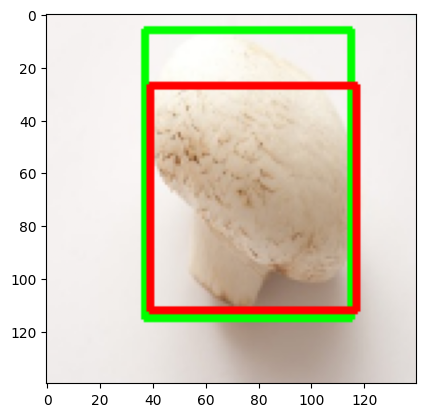

In [ ]:
model.load_state_dict(torch.load('/content/best_model.pt'))
model.eval()

with torch.no_grad():

    image, gt_bbox = validset[29] # (c,h,w)
    image = image.unsqueeze(0).to(DEVICE) # (bs, c, h, w)
    out_bbox = model(image)

    utils.compare_plots(image, gt_bbox, out_bbox)